<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Detection-Classficiation-CNN/Generating_Annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup HD-BET

In [6]:
# Clone HD-BET repository and install requirements
!git clone https://github.com/MIC-DKFZ/HD-BET.git
%cd HD-BET
!pip install -r requirements.txt
%cd ..

fatal: destination path 'HD-BET' already exists and is not an empty directory.
/content/HD-BET
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
/content


Import Required Libraires

In [7]:
# Install necessary libraries
!pip install --upgrade tensorflow==2.18.0 segmentation-models==1.0.1 tensorflow-hub tensorflow-addons opencv-python scikit-learn kagglehub

# Uninstall and reinstall protobuf (compatible version)
!pip uninstall -y protobuf
!pip install protobuf==3.20.3

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import tensorflow.keras as keras
print("tf.keras is available.")

import segmentation_models as sm
import glob
import random
import cv2
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


TensorFlow version: 2.18.0
tf.keras is available.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Dataset

In [8]:
# Set raw dataset path (update the path as needed)
RAW_DATASET_PATH = "/content/drive/MyDrive/DSGP/DSGP_dataset"
# This folder should contain two subfolders: "tumour" and "no_tumour"

# List classes:
tumor_classes = [folder for folder in os.listdir(RAW_DATASET_PATH) if os.path.isdir(os.path.join(RAW_DATASET_PATH, folder))]
print("Detected classes:", tumor_classes)

Detected classes: ['no_tumour', 'tumour']


Preprocessing Function

In [9]:
import subprocess
from PIL import Image
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString

TARGET_SIZE = (256, 256)

def preprocess_image(img_path, target_size=TARGET_SIZE):
    """Load an image, convert to RGB, resize, and normalize."""
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size)
    img_norm = img_resized.astype(np.float32) / 255.0
    return img_norm

def run_hdbet(input_file, output_dir="hd_bet_out", device="cpu", mode="fast"):
    """Run HD-BET on a given input file."""
    os.makedirs(output_dir, exist_ok=True)
    cmd = [
        "python", "HD-BET/hd-bet.py",
        "-i", input_file,
        "-o", output_dir,
        "-device", device,
        "-mode", mode
    ]
    print("Running HD-BET on:", input_file)
    subprocess.run(cmd, check=True)
    # HD-BET outputs file with '_brain.nii.gz'
    base = os.path.basename(input_file)
    if base.endswith(".nii.gz"):
        base = base[:-7]
    elif base.endswith(".nii"):
        base = base[:-4]
    output_file = os.path.join(output_dir, base + "_brain.nii.gz")
    if os.path.exists(output_file):
        return output_file
    else:
        raise FileNotFoundError("HD-BET output not found:", output_file)

def generate_bbox_from_mask(mask, threshold=0.5):
    # Squeeze to ensure the mask is 2D (if shape is (H,W,1) or similar)
    mask = np.squeeze(mask)
    bin_mask = (mask > threshold).astype(np.uint8)
    ys, xs = np.where(bin_mask == 1)
    if len(xs) == 0 or len(ys) == 0:
        return None
    xmin, xmax = np.min(xs), np.max(xs)
    ymin, ymax = np.min(ys), np.max(ys)
    return [xmin, ymin, xmax, ymax]

def create_pascal_voc_xml(image_path, bbox, label, save_dir):
    """Generate a PASCAL VOC XML annotation file."""
    image_name = os.path.basename(image_path)
    xml_filename = os.path.splitext(image_name)[0] + ".xml"
    root = ET.Element("annotation")
    ET.SubElement(root, "filename").text = image_name
    size = ET.SubElement(root, "size")
    ET.SubElement(size, "width").text = str(TARGET_SIZE[0])
    ET.SubElement(size, "height").text = str(TARGET_SIZE[1])

    obj = ET.SubElement(root, "object")
    ET.SubElement(obj, "name").text = label
    bbox_elem = ET.SubElement(obj, "bndbox")
    for tag, value in zip(["xmin", "ymin", "xmax", "ymax"], bbox):
        ET.SubElement(bbox_elem, tag).text = str(value)

    xml_str = parseString(ET.tostring(root)).toprettyxml()
    with open(os.path.join(save_dir, xml_filename), "w") as f:
        f.write(xml_str)

Generate Annotations

In [10]:
# Load the U-Net model (make sure to include any custom_objects if needed)
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + smooth)

# Remove unet_model.summary() to avoid printing model architecture
unet_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/DSGP/U-Net model/U-Net.h5",
    custom_objects={"dice_coefficient": dice_coefficient}
)

def process_dataset_for_detection(raw_dataset_path, output_images_dir, output_ann_dir, unet_model, hd_bet=True):
    """
    For each image in the raw dataset (organized in folders 'tumour' and 'no_tumour'),
    perform preprocessing, optionally run skull stripping with HD-BET, generate segmentation masks
    using the U-Net model, convert masks to bounding boxes, and save preprocessed images and
    annotations (PASCAL VOC XML) for detection training.
    """
    classes = [
        folder for folder in os.listdir(raw_dataset_path)
        if os.path.isdir(os.path.join(raw_dataset_path, folder))
    ]
    for cls in classes:
        # Optional: print(f"\nProcessing class: {cls}") # Removed for minimal output
        class_dir = os.path.join(raw_dataset_path, cls)
        image_files = [
            os.path.join(class_dir, f)
            for f in os.listdir(class_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

        # Create output directories
        img_out_dir = os.path.join(output_images_dir, cls)
        ann_out_dir = os.path.join(output_ann_dir, cls)
        os.makedirs(img_out_dir, exist_ok=True)
        os.makedirs(ann_out_dir, exist_ok=True)

        for image_path in image_files:
            # Preprocess image (resize, normalize)
            image = preprocess_image(image_path)

            # Optionally, apply skull stripping on the raw image (if you have NIfTI)
            if hd_bet:
                try:
                    skull_stripped_path = run_hdbet(
                        image_path, output_dir="hd_bet_out", device="cpu", mode="fast"
                    )
                    image = preprocess_image(skull_stripped_path)
                except Exception as e:
                    # Minimizing logs
                    pass

            # Generate segmentation mask using the U-Net model, suppressing the progress bar
            img_resized = tf.image.resize(image, TARGET_SIZE)
            img_batch = tf.expand_dims(img_resized, axis=0)
            mask = unet_model.predict(img_batch, verbose=0)[0]  # shape (256,256,1)

            # Convert the predicted mask to a bounding box
            bbox = generate_bbox_from_mask(mask, threshold=0.5)
            if bbox is None:
                # For no tumor, use full image as bbox
                bbox = [0, 0, TARGET_SIZE[0], TARGET_SIZE[1]]

            # Save the preprocessed image (convert back to 0-255 uint8)
            img_save = (image * 255).astype(np.uint8)
            img_save = cv2.resize(img_save, TARGET_SIZE)
            img_save_path = os.path.join(img_out_dir, os.path.basename(image_path))
            Image.fromarray(img_save).save(img_save_path)

            # Save the annotation as a PASCAL VOC XML file
            create_pascal_voc_xml(image_path, bbox, cls, ann_out_dir)
            # Minimizing logs: removed print statements

# Define output paths for detection dataset (images & annotations)
OUTPUT_IMAGES_PATH = "/content/drive/MyDrive/DSGP/Detection_Images"
OUTPUT_ANN_PATH = "/content/drive/MyDrive/DSGP/Detection_Annotations"

# Run the preprocessing/detection pipeline with no progress bars
process_dataset_for_detection(
    RAW_DATASET_PATH,
    OUTPUT_IMAGES_PATH,
    OUTPUT_ANN_PATH,
    unet_model,
    hd_bet=False  # set True if you actually have NIfTI volumes to skull strip
)

Data Augmentation & Splitting

tumour: 4590 images
Augmented image saved: /content/drive/MyDrive/DSGP/Detection_Images/tumour/tumour_aug_1575baba-c749-4df5-af74-36f0dda76f54.png
Augmented image saved: /content/drive/MyDrive/DSGP/Detection_Images/tumour/tumour_aug_fcfb235b-df0b-497d-91f3-787a2d19479e.png
Augmented image saved: /content/drive/MyDrive/DSGP/Detection_Images/tumour/tumour_aug_5c742b2c-ea56-4878-801b-7269f4517488.png
Augmented image saved: /content/drive/MyDrive/DSGP/Detection_Images/tumour/tumour_aug_8895ea93-35ce-42d6-b12e-6a22942727a9.png
Augmented image saved: /content/drive/MyDrive/DSGP/Detection_Images/tumour/tumour_aug_cf68789a-899d-4cdf-8587-ba73007bca1f.png
Augmented image saved: /content/drive/MyDrive/DSGP/Detection_Images/tumour/tumour_aug_1f749495-c711-4fcb-9daa-cfca397bd646.png
Augmented image saved: /content/drive/MyDrive/DSGP/Detection_Images/tumour/tumour_aug_dd121696-4646-4180-a528-64994b93934c.png
Augmented image saved: /content/drive/MyDrive/DSGP/Detection_Images/tumour/tumour_aug_9524c

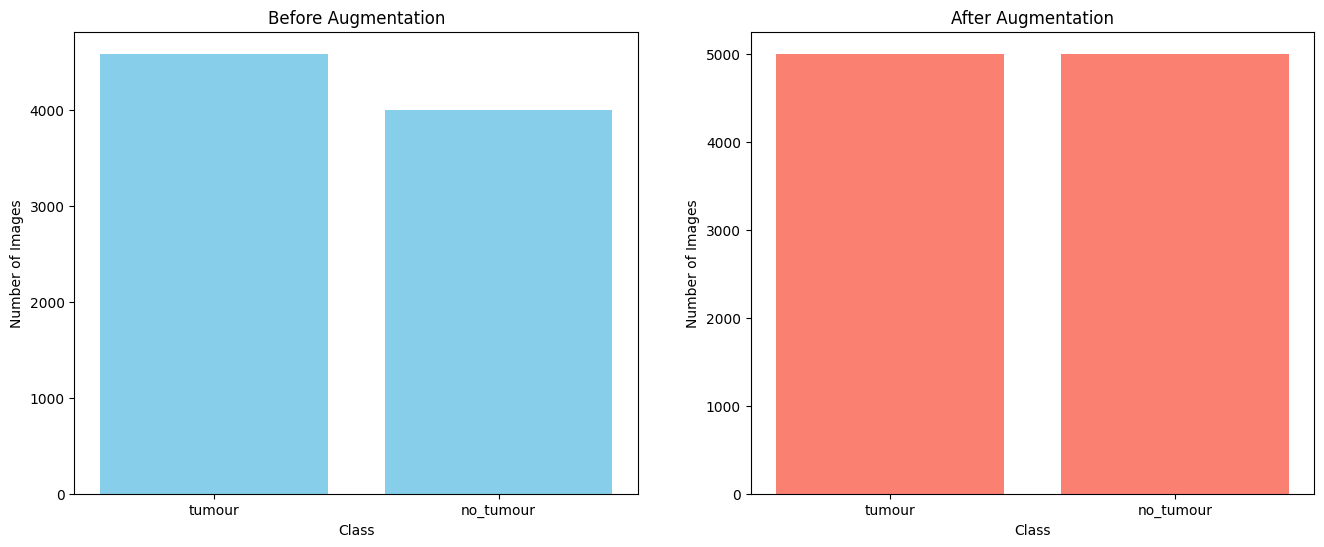

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import uuid

# Data augmentation generator
augmentor = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

def augment_image(image_path, count, save_dir, label):
    """
    Augment a single image and save augmented versions.
    """
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)
    for i in range(count):
        aug_img = next(augmentor.flow(image, batch_size=1, shuffle=False))[0]
        aug_img_uint8 = (aug_img * 255).astype(np.uint8)
        unique_id = str(uuid.uuid4())
        save_path = os.path.join(save_dir, f"{label}_aug_{unique_id}.png")
        Image.fromarray(aug_img_uint8).save(save_path)
        print(f"Augmented image saved: {save_path}")

def balance_classes(raw_dataset_path, output_dir, label):
    """
    For a given class (folder), count images and perform augmentation to reach a target count.
    """
    class_dir = os.path.join(raw_dataset_path, label)
    images = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    current_count = len(images)
    target_count = max(1, current_count)  # set a target (or a fixed number if desired)
    print(f"{label}: {current_count} images")
    # For example, if you want 5000 images per class:
    desired_count = 5000
    if current_count < desired_count:
        extra_needed = desired_count - current_count
        # Augment random images from the class folder
        for img_path in random.choices(images, k=extra_needed):
            augment_image(img_path, 1, output_dir, label)
    # Return the new list of image paths
    new_images = [os.path.join(output_dir, f) for f in os.listdir(output_dir)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    return new_images

# Example: balance classes in the detection dataset that you created.
# Assume OUTPUT_IMAGES_PATH has two subfolders: "tumour" and "no_tumour"
balanced_tumour = balance_classes(OUTPUT_IMAGES_PATH, os.path.join(OUTPUT_IMAGES_PATH, "tumour"), "tumour")
balanced_no_tumour = balance_classes(OUTPUT_IMAGES_PATH, os.path.join(OUTPUT_IMAGES_PATH, "no_tumour"), "no_tumour")

# Plot class distributions before and after augmentation
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

import matplotlib.pyplot as plt

classes = ["tumour", "no_tumour"]
before_counts = {cls: count_images(os.path.join(RAW_DATASET_PATH, cls)) for cls in classes}
after_counts = {cls: count_images(os.path.join(OUTPUT_IMAGES_PATH, cls)) for cls in classes}

fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].bar(before_counts.keys(), before_counts.values(), color="skyblue")
axes[0].set_title("Before Augmentation")
axes[0].set_ylabel("Number of Images")
axes[0].set_xlabel("Class")

axes[1].bar(after_counts.keys(), after_counts.values(), color="salmon")
axes[1].set_title("After Augmentation")
axes[1].set_ylabel("Number of Images")
axes[1].set_xlabel("Class")
plt.show()

Visualizing a Tumor Region

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


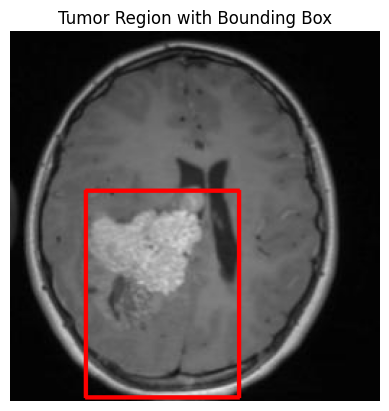

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


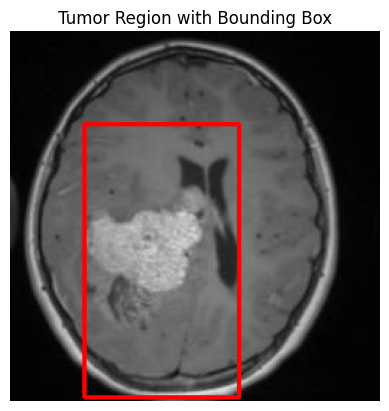

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


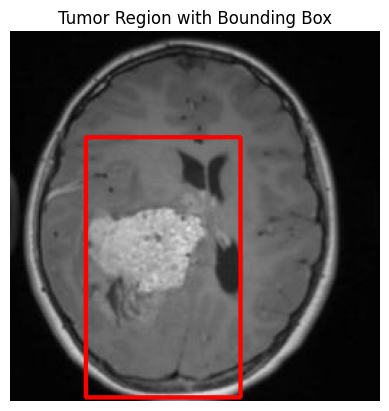

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


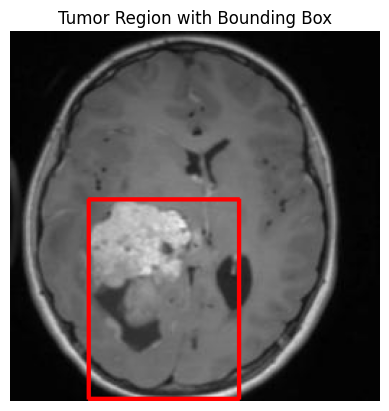

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


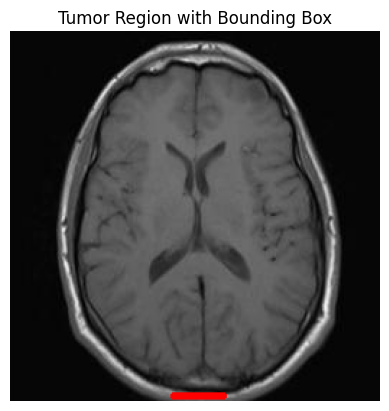

In [19]:
def visualize_tumor_with_bbox(image_path, unet_model):
    """Visualize an image with its tumor region bounding box."""
    # Preprocess image
    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Error: Image file not found: {image_path}")
        return  # Or raise an exception

    image = preprocess_image(image_path)
    img_resized = tf.image.resize(image, TARGET_SIZE)
    img_batch = tf.expand_dims(img_resized, axis=0)
    # Generate mask using U-Net
    mask = unet_model.predict(img_batch)[0]
    # Convert mask to bounding box
    bbox = generate_bbox_from_mask(mask, threshold=0.5)
    # Prepare image for display
    disp_img = (image * 255).astype(np.uint8)
    disp_img = cv2.resize(disp_img, TARGET_SIZE)
    if bbox is not None:
        cv2.rectangle(disp_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255,0,0), 2)
    plt.imshow(disp_img)
    plt.title("Tumor Region with Bounding Box")
    plt.axis("off")
    plt.show()

# Example: Visualize an image from the 'tumour' class
# Make sure 'example_image' points to a valid image file
example_image = "/content/drive/MyDrive/DSGP/Detection_Images/tumour/z.jpeg"
visualize_tumor_with_bbox(example_image, unet_model)
example_image = "/content/drive/MyDrive/DSGP/Detection_Images/tumour/x.jpeg"
visualize_tumor_with_bbox(example_image, unet_model)
example_image = "/content/drive/MyDrive/DSGP/Detection_Images/tumour/v.jpeg"
visualize_tumor_with_bbox(example_image, unet_model)
example_image = "/content/drive/MyDrive/DSGP/Detection_Images/tumour/yw54y.jpeg"
visualize_tumor_with_bbox(example_image, unet_model)
example_image = "/content/drive/MyDrive/DSGP/Detection_Images/no_tumour/Tr-noTr_0002.jpg"
visualize_tumor_with_bbox(example_image, unet_model)